# ROMY Barometer - Statistic Plots

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy import read_inventory

from andbro__read_sds import __read_sds

In [2]:
from functions.get_mean_promy_pressure import __get_mean_promy_pressure
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

In [3]:
#%matplotlib tk

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [5]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_baro/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_baro/data/"

config['tbeg'] = obs.UTCDateTime("2024-03-01")
config['tend'] = obs.UTCDateTime("2024-06-30")

## Load Data

In [6]:
def __load_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime
    from tqdm.notebook import tqdm

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in tqdm(date_range(t1, t2)):
        # print(str(dat)[:10])
        file = f"RB_statistics_{str(dat)[:10]}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    # df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [(_t2 - _t1)/2 + _t1 for _t1, _t2 in zip(df.t1, df.t2)]

    return df

In [8]:
df = __load_data(config['tbeg'], config['tend'], config['path_to_data'])

  0%|          | 0/122 [00:00<?, ?it/s]

error for RB_statistics_2024-04-11.pkl


In [ ]:
# df = pd.read_pickle(config['path_to_data']+"RB_statistics_2024-03-01_2024-03-10.pkl")

In [9]:
df = df[df.status == False]

In [10]:
df.keys()

Index(['t1', 't2', 'status', 'shift_PP_N', 'shift_PP_E', 'shift_PP_Z',
       'shift_HP_N', 'shift_HP_E', 'shift_HP_Z', 'cmax_PP_N', 'cmax_PP_E',
       'cmax_PP_Z', 'cmax_HP_N', 'cmax_HP_E', 'cmax_HP_Z', 'r_z', 'r_n', 'r_e',
       'a_z', 'a_n', 'a_e', 'b_z', 'b_n', 'b_e', 'time_sec'],
      dtype='object')

In [11]:
for k in ["shift_PP_N", "shift_PP_E", "shift_HP_N", "shift_HP_E"]:
    df[k] = df[k]/20 # 20 Hz sampling rate


In [12]:
# df = df[df.b_e != 0]

In [13]:
df

,t1,t2,status,shift_PP_N,shift_PP_E,shift_PP_Z,shift_HP_N,shift_HP_E,shift_HP_Z,cmax_PP_N,...,r_z,r_n,r_e,a_z,a_n,a_e,b_z,b_n,b_e,time_sec
1,1.709257e+09,1.709264e+09,False,-69.20,168.60,-8377.0,-5170.65,-103.45,-1464.0,0.503531,...,62.47,24.74,40.77,8.221727e-12,2.016140e-11,-8.120586e-12,-2.620604e-11,4.758325e-12,1.079573e-11,1.709260e+09
2,1.709262e+09,1.709269e+09,False,-5730.50,-6455.30,-117384.0,-6118.60,-6142.45,-108825.0,0.596709,...,1.20,13.40,11.09,1.577833e-12,1.476164e-11,-5.834479e-12,-6.824760e-13,1.185267e-11,-2.755055e-12,1.709266e+09
3,1.709267e+09,1.709275e+09,False,-1174.35,-3208.85,-25850.0,-746.20,-3615.10,-33382.0,-0.663850,...,17.68,18.78,8.90,4.661186e-12,2.811077e-11,-7.949762e-12,1.089175e-11,2.748155e-11,-8.274224e-12,1.709271e+09
4,1.709273e+09,1.709280e+09,False,-388.75,-1190.15,-10979.0,-814.55,-663.85,-20380.0,-0.708019,...,20.33,24.97,18.59,1.127912e-12,-8.872493e-12,6.663475e-12,-3.680926e-12,-2.460306e-11,8.626178e-12,1.709276e+09
5,1.709278e+09,1.709285e+09,False,-5159.25,-5766.70,-128316.0,-5446.25,-6064.70,-120426.0,-0.529467,...,0.26,0.54,1.50,-1.681662e-12,-5.814461e-12,5.079489e-12,2.451133e-12,6.857269e-13,-1.104540e-12,1.709282e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1.719247e+09,1.719254e+09,False,-20.30,-26.10,-112900.0,-2435.50,-2435.60,-121891.0,-0.587742,...,1.89,34.96,33.51,-1.198561e-12,-1.951024e-10,1.099375e-10,1.984351e-13,9.598344e-12,-3.152955e-12,1.719250e+09
1724,1.719263e+09,1.719270e+09,False,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.719266e+09
1730,1.719301e+09,1.719308e+09,False,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.719304e+09
1751,1.719419e+09,1.719427e+09,False,-5600.35,-5617.20,-128417.0,-5261.30,-5267.90,-119536.0,-0.591703,...,2.85,1.25,0.72,-1.068234e-12,2.214304e-11,-1.154491e-11,-4.396142e-12,5.501178e-12,1.093351e-12,1.719423e+09


In [14]:
# select only those with CC > 0.7
cc_threshold = 0.7
dfN = df[(df.cmax_PP_N.abs() > cc_threshold) | (df.cmax_HP_N.abs() > cc_threshold)]
dfE = df[(df.cmax_PP_E.abs() > cc_threshold) | (df.cmax_HP_E.abs() > cc_threshold)]
dfZ = df[(df.cmax_PP_Z.abs() > cc_threshold) | (df.cmax_HP_Z.abs() > cc_threshold)]

# select only those with VR > 50 %
vr_threshold = 40
dfN = df[(df.r_n > vr_threshold)]
dfE = df[(df.r_e > vr_threshold)]
dfZ = df[(df.r_z > vr_threshold)]


dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
  label  lower_whisker  lower_quartile    median  upper_quartile  \
0   dfZ       0.104928        0.754474  1.676072        3.901128   
1   dfN       0.504520        2.771639  4.110894        6.843028   
2   dfE       0.167828        1.718376  2.474924        4.961762   

   upper_whisker  
0       7.036114  
1      12.825652  
2       9.814382  


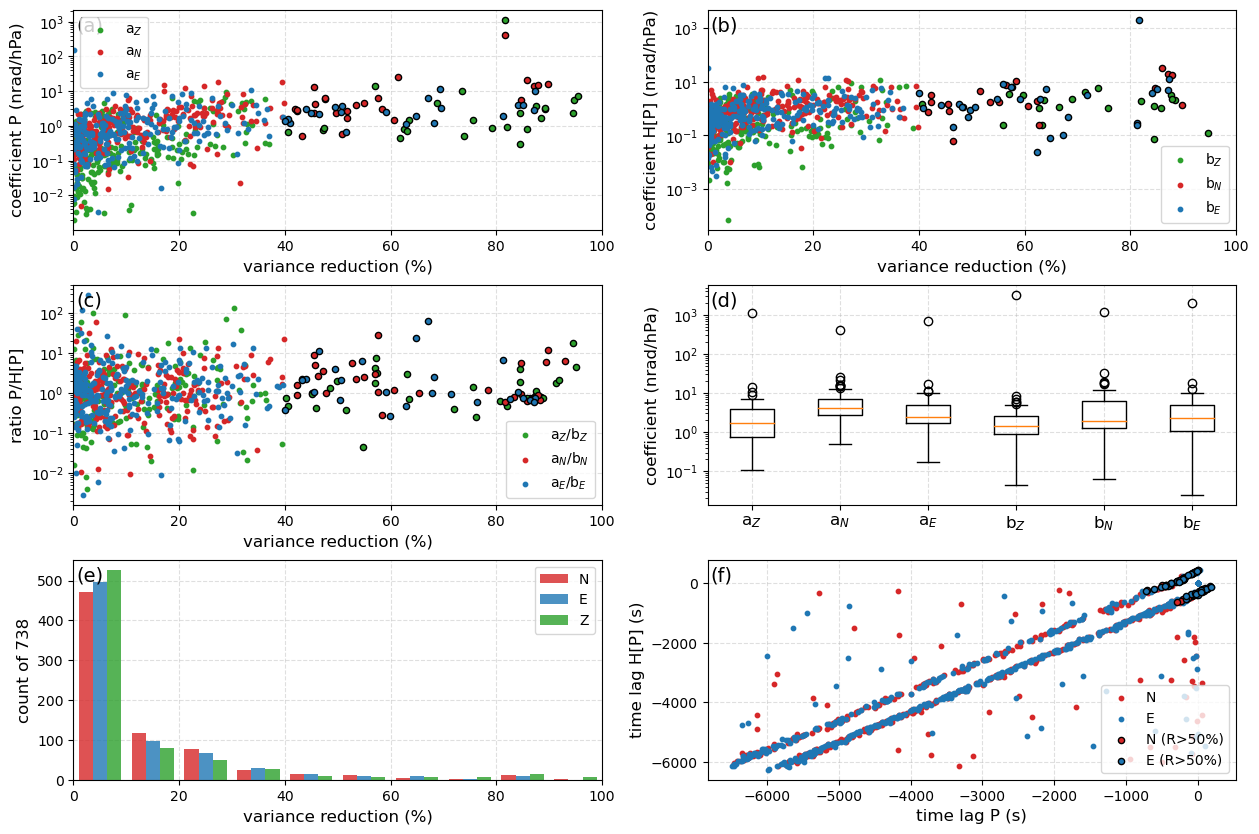

In [20]:
def __makeplot():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    def get_box_plot_data(labels, bp):
        rows_list = []

        for i in range(len(labels)):
            dict1 = {}
            dict1['label'] = labels[i]
            dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
            dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
            dict1['median'] = bp['medians'][i].get_ydata()[1]
            dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
            dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
            rows_list.append(dict1)

        return pd.DataFrame(rows_list)

    colors = {"Z":"tab:green", "N":"tab:red", "E":"tab:blue"}

    Nrow, Ncol = 3, 2

    font = 12

    ms1, ms2 = 10, 20

    scale, unit = 1e11, "nrad/hPa"

    hil = r"H[P]"

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.25)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])

    # ___________________________________________________
    ax0.scatter(df.r_z, df.a_z*scale, s=ms1, color=colors["Z"], label=r"a$_Z$", zorder=2)
    ax0.scatter(df.r_n, df.a_n*scale, s=ms1, color=colors["N"], label=r"a$_N$", zorder=2)
    ax0.scatter(df.r_e, df.a_e*scale, s=ms1, color=colors["E"], label=r"a$_E$", zorder=2)
    ax0.scatter(dfZ.r_z, dfZ.a_z*scale, s=ms2, color=colors["Z"], zorder=2, edgecolor="k")
    ax0.scatter(dfN.r_n, dfN.a_n*scale, s=ms2, color=colors["N"], zorder=2, edgecolor="k")
    ax0.scatter(dfE.r_e, dfE.a_e*scale, s=ms2, color=colors["E"], zorder=2, edgecolor="k")
    ax0.legend(fontsize=font-2)
    ax0.set_yscale("log")
    ax0.set_xlim(0, 100)
    ax0.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax0.set_ylabel(f"coefficient P ({unit})", fontsize=font)

    # ___________________________________________________
    ax1.scatter(df.r_z, df.b_z*scale, s=ms1, color=colors["Z"], label=r"b$_Z$", zorder=2)
    ax1.scatter(df.r_n, df.b_n*scale, s=ms1, color=colors["N"], label=r"b$_N$", zorder=2)
    ax1.scatter(df.r_e, df.b_e*scale, s=ms1, color=colors["E"], label=r"b$_E$", zorder=2)
    ax1.scatter(dfZ.r_z, dfZ.b_z*scale, s=ms2, color=colors["Z"], zorder=2, edgecolor="k")
    ax1.scatter(dfN.r_n, dfN.b_n*scale, s=ms2, color=colors["N"], zorder=2, edgecolor="k")
    ax1.scatter(dfE.r_e, dfE.b_e*scale, s=ms2, color=colors["E"], zorder=2, edgecolor="k")
    ax1.legend(fontsize=font-2)
    ax1.set_yscale("log")
    ax1.set_xlim(0, 100)
    ax1.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax1.set_ylabel(f"coefficient {hil} ({unit})", fontsize=font)

    # ___________________________________________________
    ax2.scatter(df.r_z, (df.a_z*scale)/(df.b_z*scale), s=ms1, color=colors["Z"], label=r"a$_Z$/b$_Z$", zorder=2)
    ax2.scatter(df.r_n, (df.a_n*scale)/(df.b_n*scale), s=ms1, color=colors["N"], label=r"a$_N$/b$_N$", zorder=2)
    ax2.scatter(df.r_e, (df.a_e*scale)/(df.b_e*scale), s=ms1, color=colors["E"], label=r"a$_E$/b$_E$", zorder=2)
    ax2.scatter(dfZ.r_z, (dfZ.a_z*scale)/(dfZ.b_z*scale), s=ms2, color=colors["Z"], zorder=2, edgecolor="k")
    ax2.scatter(dfN.r_n, (dfN.a_n*scale)/(dfN.b_n*scale), s=ms2, color=colors["N"], zorder=2, edgecolor="k")
    ax2.scatter(dfE.r_e, (dfE.a_e*scale)/(dfE.b_e*scale), s=ms2, color=colors["E"], zorder=2, edgecolor="k")
    ax2.legend(fontsize=font-2)
    # ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 100)
    ax2.set_yscale("log")
    ax2.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax2.set_ylabel(f"ratio P/{hil}", fontsize=font)

    # ___________________________________________________
    # ax3.boxplot([abs(df.a_z*scale), abs(df.a_n*scale), abs(df.a_e*scale), abs(df.b_z*scale), abs(df.b_n*scale), abs(df.b_e*scale)],)
    bp = ax3.boxplot([abs(dfZ.a_z*scale), abs(dfN.a_n*scale), abs(dfE.a_e*scale), abs(dfZ.b_z*scale), abs(dfN.b_n*scale), abs(dfE.b_e*scale)],)
    ax3.set_yscale("log")
    lbls = [r"a$_Z$", r"a$_N$", r"a$_E$", r"b$_Z$", r"b$_N$", r"b$_E$"]
    ax3.set_xticklabels(lbls, fontsize=font)
    ax3.set_ylabel(f"coefficient ({unit})", fontsize=font)

    # ___________________________________________________
    ax4.hist([df.r_n, df.r_e, df.r_z], bins=10, range=[0, 100], alpha=0.8,
             rwidth=0.8, align="mid", density=False, zorder=2,
             color=[colors["N"], colors["E"], colors["Z"]], label=["N", "E", "Z"],
            )
    ax4.grid(alpha=0.2, ls="--", zorder=0)
    ax4.set_xlim(0, 100)
    ax4.legend(fontsize=font-2)
    ax4.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax4.set_ylabel(f"count of {df.shape[0]}", fontsize=font)

    # ___________________________________________________
    # ax5.scatter(df.r_z, df.a_z, color=colors["Z"], label=r"b$_Z$", zorder=2)
    ax5.scatter(df.shift_PP_N, df.shift_HP_N, s=ms1, color=colors["N"], label=r"N", zorder=2)
    ax5.scatter(df.shift_PP_E, df.shift_HP_E, s=ms1, color=colors["E"], label=r"E", zorder=2)
    ax5.scatter(dfN.shift_PP_N, dfN.shift_HP_N, s=ms2, color=colors["N"], label=r"N (R>50%)", zorder=2, edgecolor="k")
    ax5.scatter(dfE.shift_PP_E, dfE.shift_HP_E, s=ms2, color=colors["E"], label=r"E (R>50%)", zorder=2, edgecolor="k")
    ax5.legend(fontsize=font-2, loc=4)
    # ax5.set_ylim(-2, 2)
    # ax5.set_xlim(0, 100)
    ax5.set_xlabel(f"time lag P (s)", fontsize=font)
    ax5.set_ylabel(f"time lag {hil} (s)", fontsize=font)

    ax0.text(.005, .97,"(a)", ha='left', va='top', transform=ax0.transAxes, fontsize=font+2)
    ax1.text(.005, .97,"(b)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97,"(c)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97,"(d)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97,"(e)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97,"(f)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)


    axes = [ax0, ax1, ax2, ax3, ax4, ax5]
    for ax in axes:
        ax.grid(ls="--", alpha=0.4, zorder=0)

    print(bp.keys())
    print(get_box_plot_data(["dfZ", "dfN", "dfE"], bp))

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"RB_statistic_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')
